# Problem Set 3
## Learning from data [TIF285], Chalmers, Fall 2019

Last revised: 09-Oct-2019 by Christian Forssén [christian.forssen@chalmers.se]

## Instructions

- See deadline on the course web page
- This problem set is performed individually (but collaboration is encouraged) and contains a number of basic and extra problems; you can choose which and how many to work on.
- See examination rules on the course web page.
- Hand-in is performed through the following **two** actions:
  - Upload of your solution in the form of a jupyter notebook, or python code, via Canvas.
  - Answer the corresponding questions on OpenTA.
  
  Note that the hand-in is not complete, and will not be graded, if any of those actions is not performed.

Fill your personal details
- Name: **Holmin, Sebastian**
- Personnummer: **970602-3679**
  <br/>
  (civic registration number)

## Problems
The 10 basic points of this problem set are distributed over four problems:
1. Assigning probabilities for a hundred-sided die (2 basic points)
2. Chi-squared hypothesis testing (2 basic points)
3. Gaussian process regression (3 basic points)
4. Neural network classification (3 basic points)

Each of them will be presented in a separate jupyter notebook.

## Problem 3: Gaussian process regression
### (3 basic points)

In the following we will perform Gaussian Process regression of the [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) ($\mu$) vs. [redshift](https://en.wikipedia.org/wiki/Redshift) ($z$) relation for a simulated set of 100 supernovas.

The data, 
$(z, \mu, \Delta \mu)$,
is generated from an underlying true distribution $p(z) \propto (z/z_0)^2 \exp[(z/z_0)^{1.5}]$ 
with $z_0 = 0.3$. An array with $(z_\mathrm{true}, \mu_\mathrm{true})$ is also available for comparison.

Credit: The data and a part of the problem formulation is obtained from the [AstroML]("http://www.astroml.org/") python module distributed under the 3-clause BSD license. For more information, see http://astroML.github.com.

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import GPy

# Not really needed, but nicer plots
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

### Task 1
Load the experimental data and the true function data and plot $\mu = \mu(z)$. 

In [3]:
# Load experimental data sample
z_sample, mu_sample, dmu = np.loadtxt('cosmology_sample.dat',unpack=True)

# data must be two-dimensional for GPy
x = z_sample.reshape((-1,1))
y = mu_sample.reshape((-1,1))
print('The experimental data is of shape:', y.shape)

The experimental data is of shape: (100, 1)


The true function data is of shape: (1000,)
Average error:  0.9429548917530961


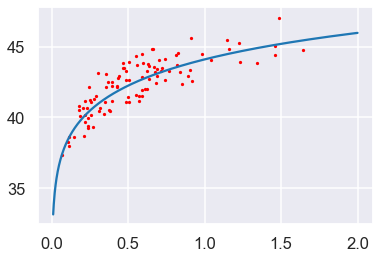

In [7]:
# Load true function
z, mu_true = np.loadtxt('cosmology_true.dat',unpack=True)

print('The true function data is of shape:', mu_true.shape)

plt.plot(z,mu_true)
plt.scatter(z_sample,mu_sample,c='r',s=3) #Plot the data points

#mu_new = np.interp(z_sample, z, mu_true) # Calculate the actual error, is this what you really asked for?
#print('Average error: ',np.mean(np.abs(mu_sample-mu_new)))

print('Average error: ',np.mean(dmu))

### Task 2 
Use the GPy python module to create a GP model with an RBF kernel. The GP model will contain a Gaussian noise term by default. 
* Print the hyperparameters of the kernel before doing optimization.
* Use GPy to optimize the model hyperparameters to the available data.
* Print the optimized GP model hyperparameters. Check in particular the Gaussian noise variance. Does it make sense given the uncertainites that were present in the experimental data?
* What is the log likelihood of the data with this GP model? (*Hint*: Use the GPy `model.log_likelihood()` function , where `model` is a GPy regression model)
* Plot the GP regression model together with the data (the GPy plot command will by default show the mean prediction and the 95% credibility region).

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


GP_regression.,value,constraints,priors
rbf.variance,1000.2044403420656,+ve,
rbf.lengthscale,3.0174646003635455,+ve,
Gaussian_noise.variance,1.000576716991924,+ve,


log likelihood:  -152.57170381374286


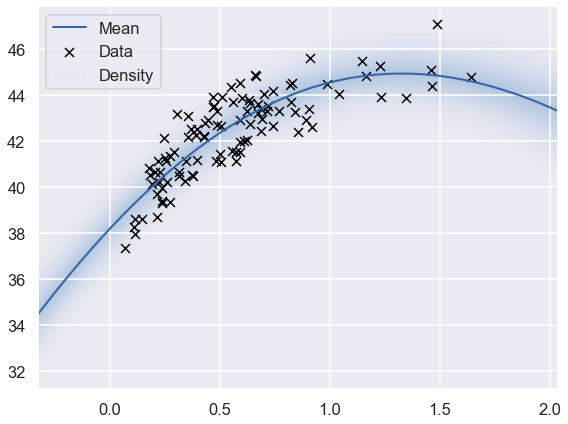

In [8]:
kernel = GPy.kern.RBF(input_dim=1)
m = GPy.models.GPRegression(x,y,kernel)
display(m)
m.optimize(messages=False)
display(m)

print("log likelihood: ",m.log_likelihood())

fig = m.plot(plot_density=True,figsize=(8,6))

### Task 3
Repeat the GP model optimization, but initialize the hyperparameters with 
* RBF lengthscale = 1.2
* RBF variance = 1000

From this initial guess, use GPy to optimize the model hyperparameters to the available data.
* Print the optimized GP model hyperparameters. 
* What is the log likelihood of the data with this GP model? 
* Plot the GP regression model together with the data.
* What are the main differences of the fit in Task 2 and the one in Task 3?

GP_regression.,value,constraints,priors
rbf.variance,1000.0,+ve,
rbf.lengthscale,1.2,+ve,
Gaussian_noise.variance,1.0,+ve,


 D:\programs\Anaconda\envs\tif285-env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


GP_regression.,value,constraints,priors
rbf.variance,1000.0000119807419,+ve,
rbf.lengthscale,1.4362310387957775,+ve,
Gaussian_noise.variance,0.9253990430421801,+ve,


log likelihood:  -151.91353925119196


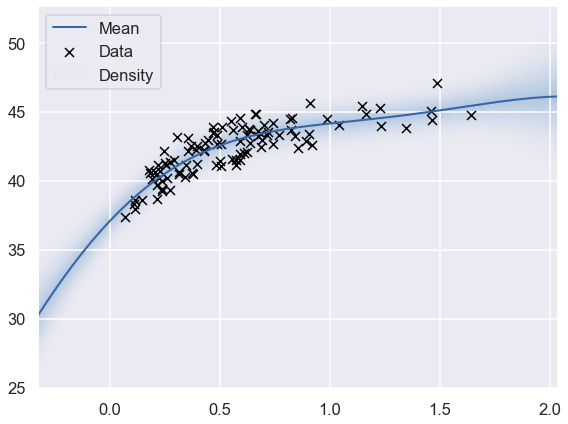

In [31]:
kernel = GPy.kern.RBF(input_dim=1, variance=1000, lengthscale=1.2)
m = GPy.models.GPRegression(x,y,kernel)
display(m)
m.optimize(messages=False)
display(m)

print("log likelihood: ",m.log_likelihood())

fig = m.plot(plot_density=True,figsize=(8,6))

### Task 4
* Create an array `Xp = numpy.linspace(0.0,2.0,50)[:,None]` to be used for predictions.
* Extract the mean vector and the covariance matrix from your GPy model object, `model`, using the command `mu, C = model.predict(Xp,full_cov=True)`
* Draw 20 samples from the multivariate Gaussian defined by `mu, C`.
* Extract the mean vector and the standard deviation vector of the 20 samples.
* Plot the sampled curves in a figure together with the mean and the $1\sigma$ and $2\sigma$ bands. (*Hint*: Use `alpha=0.3` when plotting the sampled curves in order to make them somewhat transparent).
* How does the result from this finite number of samples compare to the model plot that was produced in Task 3?

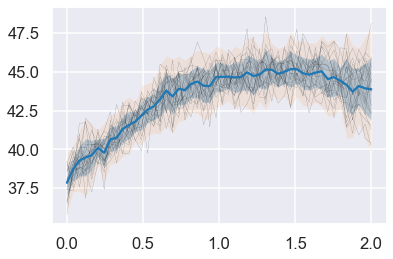

In [9]:
np.random.seed(0)
Xp = np.linspace(0.0,2.0,50)[:,None]
mu, C = m.predict(Xp,full_cov=True)

Zp = np.random.multivariate_normal(mean=mu.reshape(50), cov=C, size = 20)
mu2 = np.mean(Zp,axis=0)
sigma = np.std(Zp,axis=0)

for i in range(Zp.shape[0]): 
    plt.plot(Xp,Zp[i,:],linewidth= 0.1,color = 'black') #Plot the sampled curves in transparent black
plt.fill_between(Xp[:,0], mu2-sigma,mu2+sigma,alpha =0.3) #One sigma band
plt.fill_between(Xp[:,0], mu2-2*sigma,mu2+2*sigma,alpha =0.1) #Two sigma band
plt.plot(Xp,mu2) #Plot the mean
